# 5장. 컴퓨터 비전을 위한 딥러닝



## 5.1 합성 신경망 소개
기본적인 컨브넷 모습
- Conv2D
- MaxPooling2D

In [ ]:
# 간단한 커브넷 만들기
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

컨브넷 입력 텐서
- (image_height, image_width, image_channels)

In [ ]:
# 컨브넷 구조 출력
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


Conv2D, MaxPooling2D 층의 출력
- (height, width, channels)
- 높이와 너비는 네트워크가 깊어지면 작아지는 경향이 있음
- 채널의 수는 Conv2D 층에 전달 된 첫 번째 매개변수에 의해 조절

In [ ]:
# 컨브넷 위에 분류기 추가하기
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))

Dense층은 1D 벡터를 처리  
Flatten()을 이용해 3D를 1D로 펼치기

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

(3, 3, 64) 출력이 (576,) 크기의 벡터로 펼침  
- 576 = 3 * 3 * 64


In [ ]:
# MNIST 이미지에 컨브넷 훈련하기
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
model.fit(train_images, train_labels, epochs = 5, batch_size = 64)

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 3s 4ms/step - loss: 0.1799 - accuracy: 0.9438
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0466 - accuracy: 0.9858
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0324 - accuracy: 0.9899
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.0242 - accuracy: 0.9922
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0183 - accuracy: 0.9944


In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 3ms/step - loss: 0.0521 - accuracy: 0.9851


In [ ]:
test_acc

0.9850999712944031

2장의 완전 연결 네트워크
- 정확도 97.9 %

기본적인 컨브넷
- 정확도 98.5%

완전 연결된 모델보다 컨브넷이 더 잘 작동

### 합성곱 연산
완전 연결 층과 합성곱 층의 차이
- Dense 층은 입력 특성 공간에 있는 전역 패턴만 학습
- 합성곱 층은 지역 패턴 학습

컨브넷의 성질
- 학습된 패턴은 평행 이동 불변성을 가진다.
> 완전 연결층은 한 패턴의 위치가 바뀌면 이를 인식할 수 없음  
> 컨브넷은 위치가 어디든 인식 할 수 있음  
> 즉, 일반화 능력을 가진 표현을 학습할 수 있음
- 컨브넷은 패턴의 공간적 계층 구조를 학습할 수 있다.
> 작은 지역 패턴을 점차 넓혀가면서 학습 함

**합성곱 연산**  
- 합성곱 연산은 특성 맵이라 부루는 3D 텐서에 적용  
> 여기서에 텐서는 2개의 공간 축(높이와 너비)과 깊이 축(채널 축)으로 구성 됨
- 입력 특성 맵에서 작은 패치들을 추출
- 모든 패치들에 같은 변환 적용하여 출력 특성 맵 만듦
> 여기서 발생 되는 텐서도 3D 지만,  
> 텐서의 깊이는 층의 매개변수로 결정 돼 RGB를 나타낼 수도 아닐 수도 있음
> 대신 필터로써 표현 함

합성곱의 핵심적인 파라미터
- 입력으로부터 뽑아낼 패치의 크기
 > (window_height, window_width)
- 특성 맵의 출력 깊이 : 합성곱으로 계산할 필터의 수
 > output_depth

즉, Conv2D(output_depth, (window_height, window_width))

합성곱 작동 방법  
- 3x3 또는 5x5 크기의 윈도우 생성
- 윈도우가 3D 입력 특성 맵 위를 슬라이딩 하며 특성 패치 추출
- 3D 패치는 크기 1D 벡터로 변환
- 변환된 모든 벡터는 (height, width, output_depth) 크기의 3D 특성 맵으로 재구성

이때 출력 높이와 너비는 입력의 높이, 너비와 다를 수 있음
- 경계 문제, 입력 특성 맵에 패딩을 추가해 대응
- 스트라이드 사용 여부

### 경계 문제와 패딩 이해하기

**입력 특성 맵 가장자리에 적절한 개수의 행과 열을 추가하는 것**  

입력과 동일한 높이와 너비를 가진 출력 특성맵을 얻고 싶을 때
- 패딩 사용


### 합성곱 스트라이드 이해하기

**두번의 연속적인 윈도우 사이의 거리**
> 윈도우 첫번째 x축 시작점과 두번째 시작점 과의 거리

스트라이드 값을 조절해 다운 샘플링 할 수 있음  
하지만, `Max pooling` 연산을 더 많이 씀

### 최대 풀링 연산

**입력 특성 맵에서 윈도우에 맞는 패치를 추출하고 각 채널별로 최대값을 출력**  

합성곱과의 차이  
- 합성곱은 선형 변환 적용
- 최대 풀링은 최대값 추출 연산 사용
- 최대 풀링은 특성 맵 절반 크기로 다운 생플링 함






In [ ]:
# 합성곱으로만 이루어진 모델
from keras import models
from keras import layers

model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

In [ ]:
model_no_max_pool.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


합성곱만으로 이루어진 모델의 문제점
- 특성의 공간적 계층 구조를 학습하는데 도움이 되지 않음
> 마지막 합성곱 층의 특성이 전체 입력에 대한 정보를 갖고 있어야 함
- 최종 특성 맵의 파라미터수가 아주 많음 (22 * 22 * 64)
> Dense 층과 연결 할 때 1580만 개(512 * 22 * 22 * 64)의 가중치 파라미터 발생  
> 작은 모델치고 가중치가 많아 과대적합 발생

다운 샘플링의 이유
- 처리할 특성 맵의 가중치 개수 줄이기 위해
- 연속적인 합성곱 층이 점점 커진 윈도우를 통해 바라보도록 만들어 필터의 공간적인 계층 구조 구성





## 5.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기

소규모의 데이터셋의 개수
- 수백 개 ~ 수만 개

소규모 데이터셋의 문제를 해결하기위한 전략
- 처음부터 새로운 모델 훈련
- 사전 훈련된 네트워크로 특성 추출
- 사전 훈련된 네트워크를 세밀하게 튜닝

### 작은 데이터셋 문제에서의 딥러닝의 타당성
매우 고차원적인 문제에선 데이터가 많아야 함  
하지만, 이는 상대적인 개념
> 네트워크의 크기와 깊이에 상대적

모델이 작고 규제가 잘 돼 있는 간단한 작업은 적은 양의 샘플로도 충분



### 데이터 내려받기

#### 강아지 vs 고양이 데이터 셋
**2만 5천개의 강아지와 고양이 이미지를 담고있는 데이터 셋**  

[캐글 강아지 vs 고양이 데이터셋](https://www.kaggle.com/c/dogs-vs-cats/data)에서 다운받아서 사용



In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

구글 드라이브에 `datasets` 폴더 안에 파일을 넣어서 사용함

In [ ]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
# 훈련, 검증, 테스트 폴더로 이미지 복사하기
import os, shutil

original_dataset_dir = './datasets/cats_and_dogs/train'

base_dir = './datasets/cats_and_dogs_small'
os.mkdir(base_dir)

In [ ]:
# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [ ]:
# 훈련용, 검증용, 테스트용 고양이 및 강아지 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

In [ ]:
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
print('훈련용 고양이 이미지 전체 개수:', len(os.listdir(train_cats_dir)))
print('훈련용 강아지 이미지 전체 개수:', len(os.listdir(train_dogs_dir)))

print('검증용 고양이 이미지 전체 개수:', len(os.listdir(validation_cats_dir)))
print('검증용 강아지 이미지 전체 개수:', len(os.listdir(validation_dogs_dir)))

print('테스트용 고양이 이미지 전체 개수:', len(os.listdir(test_cats_dir)))
print('테스트용 강아지 이미지 전체 개수:', len(os.listdir(test_cats_dir)))

훈련용 고양이 이미지 전체 개수: 1000
훈련용 강아지 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
검증용 강아지 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


### 네트워크 구성하기

이전보다 이미지가 크고 복잡한 문제로  
네트워크를 크게 만들어 사용

In [ ]:
# 강이지 vs 고양이 분류를 위한 소규모 컨브넷 만들기
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

이진 분류 문제로 마지막 층의 활성화 함수는 `sigmoid` 사용

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
# 모델의 훈련 설정하기
from keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr =1e-4),
              metrics = ['acc'])

### 데이터 전처리

데이터는 부동의 소수 타입의 텐서로 네트워크에 주입해야함  
데이터가 JPEG 파일일 경우는 다음의 과정을 따름
- 사진 파일을 읽음
- JPEG 콘텐츠를 RGB 픽셀 값으로 디코딩
- 부동 소수 타입의 텐서로 변환
- 픽셀 값의 스케일을 [0, 1] 사이로 조정

In [ ]:
# ImageDataGenerator를 사용하여 디렉터리에서 이미지 읽기
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


제너레이터를 사용한 데이터에 모델 훈련시키기

In [ ]:
# 배치 제너레이터를 사용하여 모델 훈련하기
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50
)

In [ ]:
# 모델 저장하기
model.save('cats_and_dogs_small_1.h5')

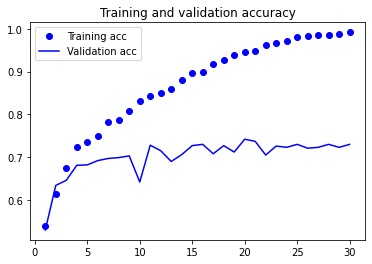

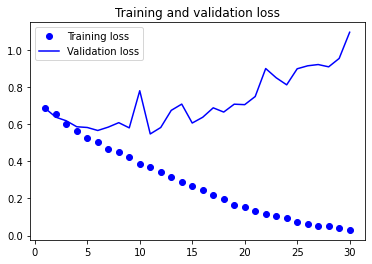

In [ ]:
# 훈련의 정확도와 손실 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

훈련 정확도는 시간이 지날 수록 거의 100%에 도달하지만,  
검증 정확도는 70~73% 에서 멈춤

훈련 손실도 시간이 지날 수록 0에 근접해 가지만,  
검증 손실의 경우 epoch 12에서 최저를 찍고 계속 증가

훈련 샘플 수가 적어 과대적합 해결이 가장 큰 문제
- 드롭아웃
- 가중치 감소

이번엔 컴퓨터 비전에 특화 돼 있는 데이터 증식 사용


### 데이터 증식 사용하기
**기존 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법**  

여러 가지 랜덤한 변환을 적용하여 샘플을 늘림


In [ ]:
# ImageDataGenerator를 사용하여 데이터 증식 설정하기
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

**ImageDataGenerator**  
- rotation_range : 랜덤하게 사진을 회전시킬 각도 (0 ~ 180)
- width_shift_range, height_shift_range : 사진을 수평과 수직으로 랜덤하게 평행 이동 (전체 너비와 높이에 대한 비율)
- shear_range : 랜덤하게 전단 변환할 각도 (회전할 때 y 축으로 좀 더 늘림)
- zoom_range : 랜덤하게 사진을 확대 및 축소
- horizontal_flip : 랜덤하게 이미지를 수평으로 뒤집음
- fill_mode : 회전이나 이동으로 인해 빈 곳을 어떻게 채울것인가에 대한 전략

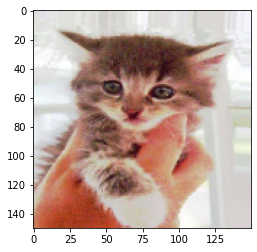

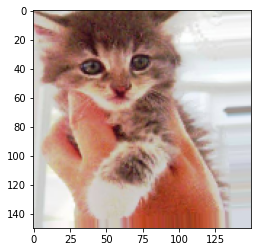

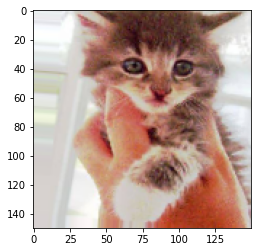

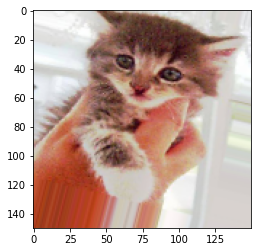

In [ ]:
# 랜덤하게 증식된 훈련 이미지 그리기
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

img_path = fnames[3]

img = image.load_img(img_path, target_size = (150, 150))

x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

데이터 증시을 사용하여 새로운 네트워크를 훈련시킬 때 네트워크에 같은 입력 데이터가 두번 주입되지 않음

하지만, 적은 수의 원본 이미지에서 만들어져 입력 데이터들 간 상호 연관성이 큼  
즉, 새로운 정보를 만들어 낼 수 없고 단지 기존 정보의 재조합만 가능

과대적합을 더 억제하기 위해 Dropout층 추가

In [ ]:
# 드롭아웃을 포함한 새로운 컨브넷 정의하기
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

In [ ]:
# 데이터 증식 제너레이터를 사용하여 컨브넷 훈련하기
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)

test_datagen  = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = (150, 150),
        batch_size = 20,
        class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size = (150, 150),
        batch_size = 20,
        class_mode = 'binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch = 100,
      epochs = 100,
      validation_data = validation_generator,
      validation_steps = 50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 20s 196ms/step - loss: 0.3402 - acc: 0.8495 - val_loss: 0.4161 - val_acc: 0.8370
Epoch 2/100
100/100 [==============================] - 19s 192ms/step - loss: 0.3540 - acc: 0.8450 - val_loss: 0.3828 - val_acc: 0.8380
Epoch 3/100
100/100 [==============================] - 19s 192ms/step - loss: 0.3358 - acc: 0.8560 - val_loss: 0.4738 - val_acc: 0.8210
Epoch 4/100
100/100 [==============================] - 19s 192ms/step - loss: 0.3415 - acc: 0.8500 - val_loss: 0.4817 - val_acc: 0.8040
Epoch 5/100
100/100 [==============================] - 19s 194ms/step - loss: 0.3279 - acc: 0.8635 - val_loss: 0.4885 - val_acc: 0.8240
Epoch 6/100
100/100 [==============================] - 19s 193ms/step - loss: 0.3419 - acc: 0.8515 - val_loss: 0.4768 - val_acc: 0.8050
Epoch 7/100
100/100 [==============================] - 19s 193ms/step - loss: 0.3408 - acc: 0.8465 - val_loss: 0.4527 - val_acc: 0.8220
Epoch 8/100
100/100 [===========================

이때 검증 데이터의 경우 데이터 증식을 사용하지 않고 스케일링만 진행

In [ ]:
# 모델 저장하기
model.save('cats_and_dogs_small_2.h5')

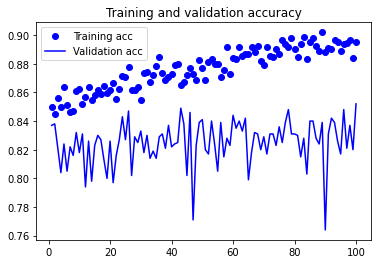

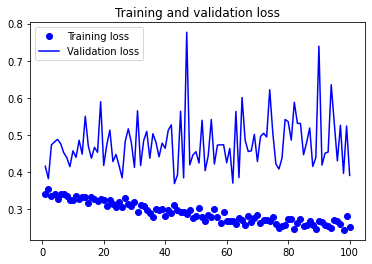

In [ ]:
# 데이터 증식을 사용했을 때 훈련 정확도와 검증 정확도
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

중간 중간 정확도가 감소하고 손실이 증가하는 경우가 있지만,  
데이터 증식과 드롭아웃 사용 후  
정확도가 약 73% 정도에서  80~84%로 이전보다 증가했으며,  
손실도 1에 가깝게 증가하는 경향을 보였으나 지금은 
약 0.4와 0.5 안팎의 손실을 보임  

즉, 과적합이 덜 일어났다고 할 수 있음

다른 규제 기법을 사용 및 파라미터 튜닝을 하면 정확도를 높일 수 있지만,  
데이터가 적어 처음부터 훈련해서 더 높은 정확도를 달성하기 힘듦

이 상황에서 정확도를 높이기 위해 사전 훈련된 컨브넷을 사용

## 5.3 사전 훈련된 컨브넷 사용하기
**대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크**  

데이터가 충분히 크고 일반적일 때 효율적인 역할을 함

이번에 사용할 모델은  
**VGG16**  
- Karen Simonyan과 Andrew Zisserman이 2014년에 개발
- ImageNet 데이터셋에서 훈련된 대규모 컨브넷
> ImageNet, 1400만개의 레이블된 이미지와 1000개의 클래스로 이루어진 데이터셋

사전 훈련된 네트워크 사용 방법
- 특성 추출
- 미세 조정



### 특성 추출
**사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아 내는 것**  

컨브넷의 구성
- **합성곱 기반 층** : 연속 된 합성곱과 풀링 층
- 완전 연결 분류기

컨브넷의 특성 추출
- 훈련된 네트워크의 합성곱 기반 층을 선택
- 새로운 데이터 통과
- 출력으로 새로운 분류기 훈련

완전 연결 분류기를 재사용하지 않는 이유
- 합성곱 층에 의한 학습된 표현이 더 일반적
- 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만 담고 있음
- 입력 이미지에 있는 객체 위치 정보를 갖고 있지 않음




In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [ ]:
# VGG16 합성곱 기반 층 만들기
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


VGG16의 매개변수
- weights : 모델을 초기화 할 가중치 체크포인트
- include_top : 네트워크의 최상위 완전 연결 분류기 포함 여부
- input_shape : 네트워크에 주입할 이미지 텐서 크기

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

최종 특성 맵의 크기는 (4, 4, 512)  

두 가지 방법을 이용해 완전 연결 층과 연결하기
- 데이터 증식을 사용하지 않는 빠른 특성 추출
- 데이터 증식을 사용한 특성 추출


#### 데이터 증식을 사용하지 않는 빠른 특성 추출


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


추출된 특성의 크기는 (samples, 4, 4, 512)로  
완전 연결 분류기에 주입하기 위해선 (sample, 4 * 4 * 512)로 펼쳐야함



In [ ]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

완전 연결 분류기 정의 후  
저장된 데이터와 레이블 사용하여 훈련

In [ ]:
# 완전 연결 분류기를 정의하고 훈련하기
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6854 - acc: 0.6061 - val_loss: 0.4491 - val_acc: 0.8420
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4635 - acc: 0.7799 - val_loss: 0.3580 - val_acc: 0.8660
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3735 - acc: 0.8454 - val_loss: 0.3245 - val_acc: 0.8770
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3200 - acc: 0.8598 - val_loss: 0.2990 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2775 - acc: 0.8882 - val_loss: 0.2815 - val_acc: 0.8910
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2713 - acc: 0.8842 - val_loss: 0.2758 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2556 - acc: 0.9098 - val_loss: 0.2685 - val_acc: 0.8920
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

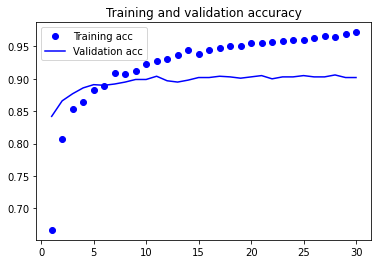

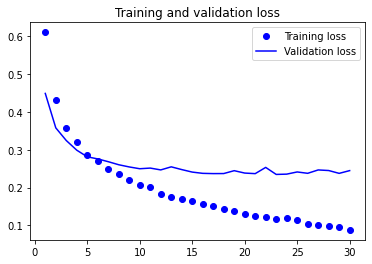

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 정확도가 약 90%에 도달  
하지만, 많은 드롭아웃을 사용해도 훈련을 시작하면서 과대적합을 보임  
이를 막기 위해 데이터 증식을 사용

#### 데이터 증식을 사용한 특성 추출

In [ ]:
# 합성곱 기반 층 위에 완전 연결 분류기 추가하기
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


모델을 컴파일하고 훈련하기 전에 합성곱 기반 층을 동결하는 것이 중요함  
> 동결, 훈련하는 동안 가중치가 업데이터 되지 않도록 막는 것  

동결하지 않으면 사전 학습 된 표현이 훈련 도중 수정 됨




In [ ]:
print('conv_base를 동결하기 전 훈련되는 가중치 수 :', len(model.trainable_weights))
conv_base.trainable = False
print('conv_base를 동결한 후 훈련되는 가중치 수 :', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치 수 : 30
conv_base를 동결한 후 훈련되는 가중치 수 : 4


In [ ]:
# 동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizers.RMSprop(lr = 2e-5),
    metrics = ['acc']
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = 50,
    verbose = 2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 - 843s - loss: 0.5638 - acc: 0.7170 - val_loss: 0.4397 - val_acc: 0.8310
Epoch 2/30
100/100 - 23s - loss: 0.4163 - acc: 0.8270 - val_loss: 0.3544 - val_acc: 0.8570
Epoch 3/30
100/100 - 23s - loss: 0.3640 - acc: 0.8515 - val_loss: 0.3172 - val_acc: 0.8680
Epoch 4/30
100/100 - 23s - loss: 0.3248 - acc: 0.8645 - val_loss: 0.2874 - val_acc: 0.8850
Epoch 5/30
100/100 - 23s - loss: 0.3095 - acc: 0.8615 - val_loss: 0.2774 - val_acc: 0.8910
Epoch 6/30
100/100 - 23s - loss: 0.2924 - acc: 0.8775 - val_loss: 0.2637 - val_acc: 0.9010
Epoch 7/30
100/100 - 23s - loss: 0.2821 - acc: 0.8860 - val_loss: 0.2787 - val_acc: 0.8900
Epoch 8/30
100/100 - 23s - loss: 0.2712 - acc: 0.8980 - val_loss: 0.2554 - val_acc: 0.9000
Epoch 9/30
100/100 - 23s - loss: 0.2661 - acc: 0.8880 - val_loss: 0.2491 - val_acc: 0.9000
Epoch 10/30
100/100 - 23s - loss: 0.2594 - acc: 0.9000 - val_loss: 0.2513 - val_acc: 0.9020
Epoch 11/30
100/100 - 23s - loss: 0.2497 - acc: 0.9010 - val_loss: 0.2472 - val_acc: 0.8

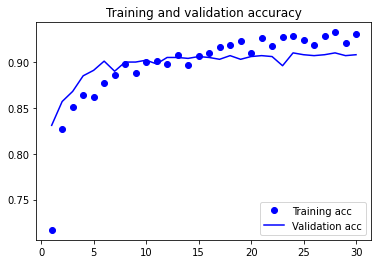

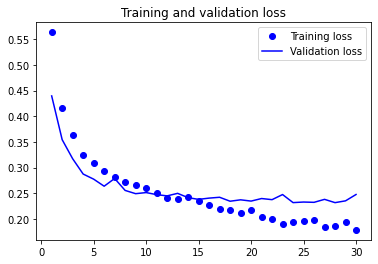

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 정확도가 이전과 비슷하지만,  
처음부터 훈련시킨 소규모 컨브넷보다 과대적합 줄어듦

### 미세 조정
**동결된 상위 층 몇개를 해제해 모델에 새로 추가한 층과 함께 훈련하는 것**  

네트워크 미세 조정 단계
1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크 추가
2. 기반 네트워크 동결
3. 새로 추가한 네트워크 훈련
4. 기반 네트워크에서 일부 층의 동결 해제
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련

3단계 까지는 특성 추출에서 이미 완료 했음.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

마지막 3개의 층만 미세 조정  
block5_conv1,block5_conv2, block5_conv3 층 미세 조정  

많은 층을 미세 조정 하지 않는 이유?
- 합성곱 기반 층의 하위 층들은 일반적인고 재사용한 가능한 특성들을 인코딩
- 상위 층은 좀 더 특화된 특성을 인코딩
- 훈련 파라미터가 많아지면 과대적합 위험 커짐

즉, 최상위 2~3개 층만 미세 조정하는 것이 좋음

In [ ]:
# 특정 층까지 모든 층 동결하기
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

네트워크 미세 조정을 위해 학습률을 낮춘 RMSprop 옵티마이저를 사용  
- 미세 조정하는 3개의 층에서 학습된 표현을 조금씩 수정하기 위함

In [ ]:
# 모델 미세 조정하기
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-5),
              metrics = ['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = 100,
    validation_data = validation_generator,
    validation_steps = 50
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 26s 255ms/step - loss: 0.2163 - acc: 0.9130 - val_loss: 0.2248 - val_acc: 0.9100
Epoch 2/100
100/100 [==============================] - 25s 250ms/step - loss: 0.1329 - acc: 0.9431 - val_loss: 0.2129 - val_acc: 0.9160
Epoch 3/100
100/100 [==============================] - 25s 247ms/step - loss: 0.1296 - acc: 0.9503 - val_loss: 0.2207 - val_acc: 0.9180
Epoch 4/100
100/100 [==============================] - 25s 250ms/step - loss: 0.1228 - acc: 0.9510 - val_loss: 0.2194 - val_acc: 0.9210
Epoch 5/100
100/100 [==============================] - 25s 249ms/step - loss: 0.0922 - acc: 0.9687 - val_loss: 0.1993 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 25s 250ms/step - loss: 0.0937 - acc: 0.9646 - val_loss: 0.2378 - val_acc: 0.9110
Epoch 7/100
100/100 [==============================] - 25s 249ms/step - loss: 0.0805 - acc: 0.9742 - val_loss: 0.2153 - val_acc: 0.9230
Epoch 8/100
100/100 [===========================

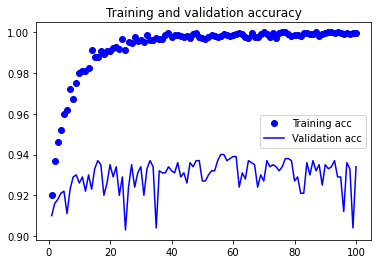

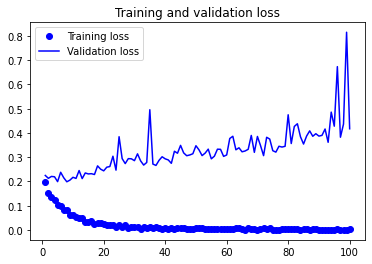

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그래프가 불규칙하게 보임  
이럴 땐 보기 쉽게 만들기 위해 지수 이동 평균 이용


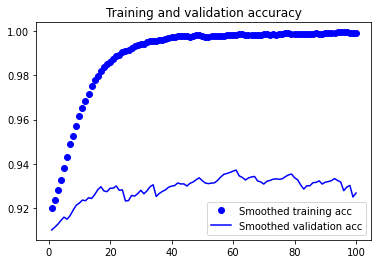

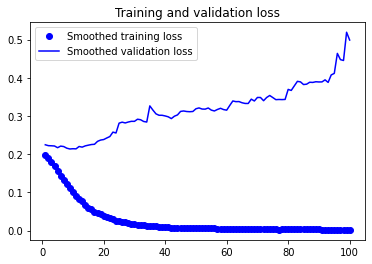

In [ ]:
# 부드러운 그래프 그리기
def smooth_curve(points, factor = 0.8):
    smoothed_points = []

    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label = 'Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label = 'Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label = 'Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label = 'Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)
print('test acc :', test_acc)

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc : 0.9359999895095825


## 5.4 컨브넷 학습 시각화
딥러닝 모델을 일반적으로 '블랙 박스' 같다고 함  
> 학습된 표현에서 사람이 이해하기 쉬운 형태를 뽑아내기 힘듦  

하지만, 컨브넷은 시각화하고 해석 가능  
그 중 세가지  
- 컨브넷 중간층의 출력을 시각화하기
- 컨브넷 필터를 시각화하기
- 클래스 활성화에 대한 히트맵을 이미지에 시각화 하기


### 중간층의 활성화 시각화하기
**네트워크에 있는 여러 합성곱과 풀링 층이 출력하는 특성 맵 그리는 것**  
> 층의 출력이 활성화 함수의 출력이라 종종 활성화라고 부름



In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

%cd /content/gdrive/MyDrive/

In [2]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [3]:
# 개별 이미지 전처리하기
img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size = (150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

print(np.shape(img))
print(img_tensor.shape)

(150, 150, 3)
(1, 150, 150, 3)


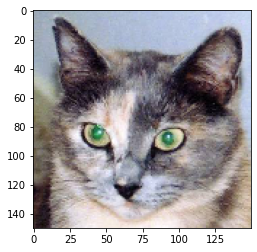

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
print(img_tensor.shape)
print(img_tensor[0].shape)

(1, 150, 150, 3)
(150, 150, 3)


특성 맵 추출을 위해 이미지 배치를 입력 받아 모든 합성곱과 풀링 층의 활성화를 출력  

2개의 매개변수를 갖는 모델 객체 생성  
- 입력 텐서
- 출력 텐서

In [4]:
# 입력 텐서와 출력 텐서의 리스트로 모델 객체 만들기
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

위 모델은 하나의 입력과 층의 활성화마다 하나씩 총 8개의 출력을 가짐

In [ ]:
# 예측 모드로 모델 실행하기
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


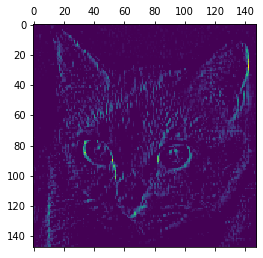

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 0], cmap = 'viridis')

위의 이미지는 첫 번째 층의 활성화 중 1번째 채널로,  
전체적인 세로 edge를 인코딩 한 것처럼 보임

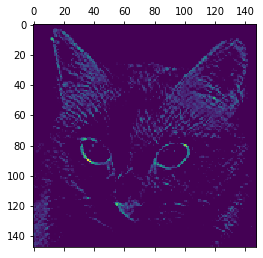

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 1], cmap = 'viridis')

위의 이미지는 첫 번째 층의 활성화 중 2번째 채널로,  
고양이의 대각선 edge를 인코딩 한 것처럼 보임

In [ ]:
# 중간층의 모든 활성화에 있는 채널 시각화하기
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

주목할 만한 내용
- 첫 번째 층은 여러 종류의 에지 감지기를 모아놓은 듯 하며, 사진의 대부분의 정보가 유지 됨
- 상위 층으로 갈수록 활성화는 점점 더 추상화 되며 '고양이 귀'와 '고양이 눈' 처럼 하나에 특화 된 고수준 개념을 인코딩.
- 상위 층의 표현은 이미지의 시각적 콘텐츠가 줄어들고 이미지의 클래스에 관한 정보가 늘어남
- 층이 깊어짐에 따라 비어 있는 활성화 층이 늘어남
- 층이 깊어 짐에 따라 활성화 되지 않는 필터가 생김
 > 즉, 필터에 인코딩된 패턴이 입력 이미지에 나타나지 않음



### 컨브넷 필터 시각화하기
**빈 입력 이미지에서 시각해서 특정 필터의 응답을 최대화하기 위해 컨브넷 입력 이미지에 경사 상승법 적용**  
> 경사 상승법, 손실 함수의 값이 커는 방향으로 그래디언트를 업데이트

In [2]:
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# 필터 시각화를 위한 손실 텐서 정의하기
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [4]:
# 입력에 대한 손실 그래디언트 구하기
grads = K.gradients(loss, model.input)[0]

경사 상승법 과정을 부드럽게 하기 위해 L2 노름을 나누어 정규화

In [5]:
# 그래디언트 정규화하기
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [6]:
# 입력 값에 대한 넘파이 출력 값 추출하기
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [8]:
# 확률적 경사 상승법을 사용한 손실 최대화하기
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])

    input_img_data += grads_value * step

In [13]:
# 텐서를 이미지 형태로 변환하기 위한 유틸리티 함수
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [14]:
# 필터 시각화 이미지를 만드는 함수
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    grads = K.gradients(loss, model.input)[0]

    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    iterate = K.function([model.input], [loss, grads])

    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

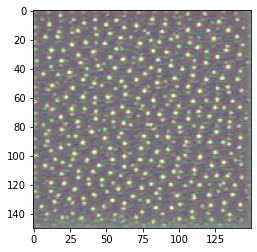

In [15]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

block3_conv1 층은 물방울 패턴에 반응 하는 것으로 보임

In [21]:
# 층에 있는 각 필터에 반응하는 패턴 생성하기
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size = size)

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    plt.figure(figsize = (20, 20))
    plt.imshow(results)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

모델 상위 층으로 갈수록 필터들은 점점 더 복잡해지고 개선 됨
- 모델의 첫 번째 층의 필터는 간단한 대각선 edge와 색깔 인코딩
- 두 번째 그림의 필터는 edge와 색깔의 조합
- 더 상위 층의 필터는 눈, 털, 피부 등과 같은 자연적 질감을 담음

### 클래스 활성화의 히트맵 시각화하기
**입력 이미지에 대한 클래스 활성화의 히트맵을 만듦**  
- 분류에 실수가 있는지를 확인 할 수 있음
- 이미지에 특정 물체의 위치를 파악할 수 있음



In [22]:
# 사전 훈련된 가중치로 VGG16 네트워크 로드하기
from tensorflow.keras.applications.vgg16 import VGG16

K.clear_session()

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 5s 0us/step


In [ ]:
from google.colab import files
files.upload()

In [35]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size = (224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

In [36]:
preds = model.predict(x)
print('Predicted :', decode_predictions(preds, top = 3)[0])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


40960/35363 [==================================] - 0s 0us/step
Predicted : [('n02504458', 'African_elephant', 0.90942144), ('n01871265', 'tusker', 0.08618243), ('n02504013', 'Indian_elephant', 0.0043545677)]


아프리카 코끼리 : 90.9%  
코끼리 : 8.6%  
인도 코끼리 : 0.4%

In [41]:
# Grad-CAM 알고리즘 설정하기
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis = -1)

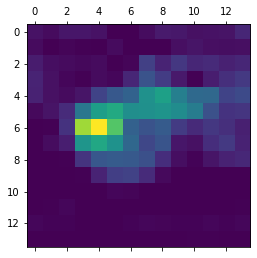

In [42]:
# 히트맵 후처리하기
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [47]:
# 원본 이미지에 히트맵 덧붙이기
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('elephant_cam.jpg', superimposed_img)

True

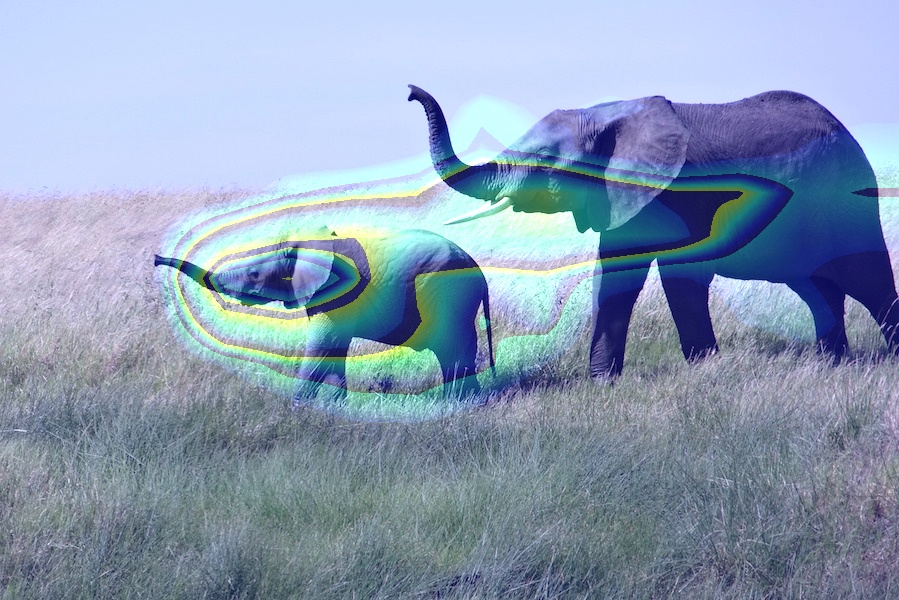

In [59]:
from IPython.display import Image

Image('elephant_cam.jpg')

위 시각화 기법은 두 가지의 중요한 질문에 답을 줌
- 왜 네트워크가 이미지에 아프리카 코끼리가 있다고 생각하는지?
- 아프리카 코끼리가 사진의 어느 위치에 있는지?